In [12]:
import sys
sys.path.append('../../../src')
from helpers import *
import sympy as sp
import matplotlib
%matplotlib notebook

if not os.path.exists('Figs'):
    os.mkdir('Figs')

### Solving the model

#### Part 1: cytoplasm vs membrane

Some definitions:

alpha = membrane conversion factor (= sa_vol ratio * cortical thickness)

d = dosage (c + alpha * m) i.e. cytoplasmic concentration if all in cytoplasm

Four solutions

In [13]:
def model1(ka, km, alpha, d):
    return (-alpha ** 2 * km ** 3 + alpha ** 2 * km ** 2 + 2 * alpha * d * ka * km ** 2 - alpha * km ** 2 * np.sqrt(
        alpha ** 2 * km ** 2 + 4 * alpha * d * ka * km ** 2 + 2 * alpha * km + 4 * d * ka + 1) - alpha * km ** 2 + alpha * km * np.sqrt(
        alpha ** 2 * km ** 2 + 4 * alpha * d * ka * km ** 2 + 2 * alpha * km + 4 * d * ka + 1) + alpha * km + 2 * d * ka) / (
                   2 * alpha ** 2 * ka * km ** 4 + 4 * alpha * ka * km ** 2 + 2 * ka)


def model2(ka, km, alpha, d):
    return (-alpha ** 2 * km ** 3 + alpha ** 2 * km ** 2 + 2 * alpha * d * ka * km ** 2 + alpha * km ** 2 * np.sqrt(
        alpha ** 2 * km ** 2 + 4 * alpha * d * ka * km ** 2 + 2 * alpha * km + 4 * d * ka + 1) - alpha * km ** 2 - alpha * km * np.sqrt(
        alpha ** 2 * km ** 2 + 4 * alpha * d * ka * km ** 2 + 2 * alpha * km + 4 * d * ka + 1) + alpha * km + 2 * d * ka) / (
                   2 * alpha ** 2 * ka * km ** 4 + 4 * alpha * ka * km ** 2 + 2 * ka)


def model3(ka, km, alpha, d):
    return (alpha ** 2 * km ** 3 + alpha ** 2 * km ** 2 + 2 * alpha * d * ka * km ** 2 - alpha * km ** 2 * np.sqrt(
        alpha ** 2 * km ** 2 + 4 * alpha * d * ka * km ** 2 - 2 * alpha * km + 4 * d * ka + 1) - alpha * km ** 2 - alpha * km * np.sqrt(
        alpha ** 2 * km ** 2 + 4 * alpha * d * ka * km ** 2 - 2 * alpha * km + 4 * d * ka + 1) - alpha * km + 2 * d * ka) / (
                   2 * alpha ** 2 * ka * km ** 4 + 4 * alpha * ka * km ** 2 + 2 * ka)


def model4(ka, km, alpha, d):
    return (alpha ** 2 * km ** 3 + alpha ** 2 * km ** 2 + 2 * alpha * d * ka * km ** 2 + alpha * km ** 2 * np.sqrt(
        alpha ** 2 * km ** 2 + 4 * alpha * d * ka * km ** 2 - 2 * alpha * km + 4 * d * ka + 1) - alpha * km ** 2 + alpha * km * np.sqrt(
        alpha ** 2 * km ** 2 + 4 * alpha * d * ka * km ** 2 - 2 * alpha * km + 4 * d * ka + 1) - alpha * km + 2 * d * ka) / (
                   2 * alpha ** 2 * ka * km ** 4 + 4 * alpha * ka * km ** 2 + 2 * ka)

#### Part 2: Monomer vs dimer

In [14]:
wd, tot, mon = sp.symbols('wd tot mon')

# Conservation of mass
dim = tot - mon

# Chemical potentials
func = (2 * sp.log(mon)) - (sp.log(dim) - wd)

sp.solve(func, mon)

[(sqrt(4*tot*exp(wd) + 1) - 1)*exp(-wd)/2,
 -(sqrt(4*tot*exp(wd) + 1) + 1)*exp(-wd)/2]

In [15]:
def dimerisation(wd, tot):
    # Takes the total density, and returns the monomer density
    mon = (np.sqrt(4 * tot * np.exp(wd) + 1) - 1) * np.exp(-wd)/2
    return mon

In [16]:
# _mon = dimerisation(8.5, 0.004)
# print((_mon / 0.004) * 100)

### Parameters

In [17]:
D = 0.005451  # molecule diameter (um) (estimated based on mw)
svr = 0.174 # surface area to volume ratio (Goehring 2011)
wm = 5  # default membrane binding energy
dos_max = 1.04e-8/0.62 # maximum dosage to run down from (based on Goehring 2011 and my estimates of membrane fraction)

### Rundowns: log transformed

<IPython.core.display.Javascript object>


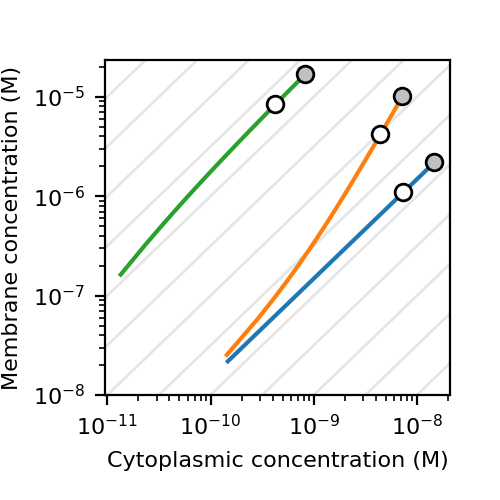

In [18]:
dim_energies = np.arange(5, 26, 1)
dosages = np.linspace(dos_max / 100, dos_max, 100)
select_energies = [6,16,26]

fig, ax = plt.subplots()

# # Plot minor lines
# for d in dim_energies:
#     cyt = model2(np.exp(d), np.exp(wm), alpha=svr*D, d=dosages)
#     mem = (dosages - cyt) / (svr*D)
#     ax.plot(np.log10(cyt), np.log10(mem), c='silver', linewidth=0.5)

# Plot major lines
for d in select_energies:
    cyt = model2(np.exp(d), np.exp(wm), alpha=svr*D, d=dosages)
    mem = (dosages - cyt) / (svr*D)
    ax.plot(np.log10(cyt), np.log10(mem))
    
# Plot full dosage points
for d in select_energies:
    cyt = model2(np.exp(d), np.exp(wm), alpha=svr*D, d=dosages[-1])
    mem = (dosages[-1] - cyt) / (svr*D)
    ax.scatter(np.log10(cyt), np.log10(mem), c='silver', edgecolors='k', zorder=10)

# Plot half dosage points
for d in select_energies:
    cyt = model2(np.exp(d), np.exp(wm), alpha=svr*D, d=dosages[-1]/2)
    mem = (dosages[-1]/2 - cyt) / (svr*D)
    ax.scatter(np.log10(cyt), np.log10(mem), c='w', edgecolors='k', zorder=10)

# Plot grid lines
xlim = ax.get_xlim()
ylim = ax.get_ylim()
for i in np.arange(-10, 10, 0.5):
    ax.plot([-20, 0], [i - 10, i + 10], c='0.9', zorder=-100, linewidth=1)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
    
ax.set_yticks([i for i in ax.get_yticks() if i % 1 == 0])
ax.set_xticks([i for i in ax.get_xticks() if i % 1 == 0])
ax.set_xlabel('Cytoplasmic concentration (M)', fontsize=8)
ax.set_ylabel('Membrane concentration (M)', fontsize=8)
ax.xaxis.set_major_formatter(fake_log)
# ax.set_yticks([-2, -1, 0, 1])
ax.yaxis.set_major_formatter(fake_log)
ax.tick_params(axis='both', labelsize=8)
minor_ticks(ax)
fig.set_size_inches(2.5, 2.5)
fig.subplots_adjust(bottom=0.21, left=0.21)
fig.savefig('Figs/rundowns_log.png', transparent=True, dpi=600)

### Rundowns: linear plot

In [19]:
# fig, ax = plt.subplots()

# for d in dim_energies:
#     cyt = model2(np.exp(d), np.exp(wm), alpha=svr*D, d=dosages)
#     mem = (dosages - cyt) / (svr*D)
#     ax.plot(cyt / 1e-6, mem / 1e-3, c='silver', linewidth=0.5)
# for d in select_energies:
#     cyt = model2(np.exp(d), np.exp(wm), alpha=svr*D, d=dosages)
#     mem = (dosages - cyt) / (svr*D)
#     ax.plot(cyt / 1e-6, mem / 1e-3)
    
# # Plot full dosage points
# for d in select_energies:
#     cyt = model2(np.exp(d), np.exp(wm), alpha=svr*D, d=dosages[-1])
#     mem = (dosages[-1] - cyt) / (svr*D)
#     ax.scatter(cyt / 1e-6, mem / 1e-3, c='silver', edgecolors='k', zorder=10)

# # Plot half dosage points
# for d in select_energies:
#     cyt = model2(np.exp(d), np.exp(wm), alpha=svr*D, d=dosages[-1]/2)
#     mem = (dosages[-1]/2 - cyt) / (svr*D)
#     ax.scatter(cyt / 1e-6, mem / 1e-3, c='w', edgecolors='k', zorder=10)
    
# ax.set_xlabel('Cytoplasmic concentration ' + r'$_{(x10^{-6})}$', fontsize=8)
# ax.set_ylabel('Membrane concentration ' + r'$_{(x10^{-3})}$', fontsize=8)
# # ax.set_xlim(left=0)
# # ax.set_ylim(bottom=0)
# # ax.axis('equal')
# # ax.text(0.95, 0.95, r'$c_m = \alpha\:c_c^{\;\;\;\beta}$', transform=ax.transAxes, fontsize=9, ha='right', va='top')
# ax.tick_params(axis='both', labelsize=8)
# fig.set_size_inches(2.5, 2.5)
# fig.subplots_adjust(bottom=0.21, left=0.21)

### Effective exponent

In [20]:
resolution = 100
mem_energies_ = np.linspace(0, 10, resolution)
dim_energies_ = np.linspace(0, 32, resolution)
X, Y = np.meshgrid(mem_energies_, dim_energies_)

cyts = np.zeros([len(dosages), 100, 100])
mems = np.zeros([len(dosages), 100, 100])
for i, d in enumerate(dosages):
    cyts[i, :, :] = model2(np.exp(Y), np.exp(X), alpha=svr*D, d=d)
    mems[i, :, :] = (d - cyts[i, :, :]) / (svr*D)   

res = np.zeros([100, 100])
for i in range(100):
    for j in range(100):
        x = cyts[:, i, j]
        y = mems[:, i, j]
        res[i, j] = np.polyfit(np.log10(x), np.log10(y), 1)[0]

<IPython.core.display.Javascript object>


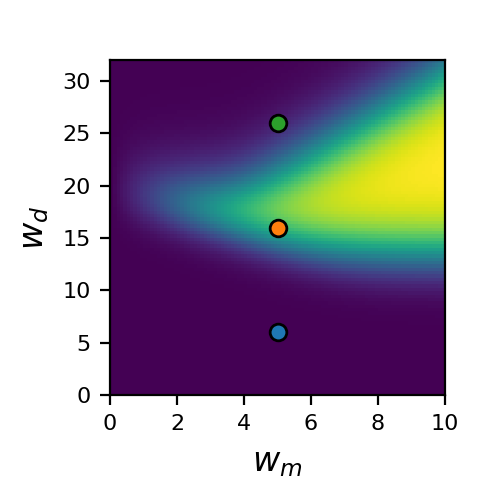

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(2.5, 2.5)
extent = (min(mem_energies_), max(mem_energies_),min(dim_energies_), max(dim_energies_))
aspect = (extent[1] - extent[0]) / (extent[3] - extent[2])
ax.imshow(res, origin='lower', extent=extent, aspect=aspect, cmap='viridis')

for y in select_energies:
    ax.scatter(5, y, edgecolors='k')

ax.set_xlabel(r'$w_m$', fontsize=12)
ax.set_ylabel(r'$w_d$', fontsize=12)
ax.tick_params(axis='both', labelsize=8)
fig.subplots_adjust(bottom=0.21, left=0.21)
fig.savefig('Figs/exponents.png', transparent=True, dpi=600)

<IPython.core.display.Javascript object>


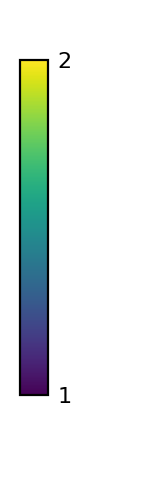

In [22]:
fig, ax = plt.subplots(figsize=(0.6, 2))
fig.set_size_inches(0.8, 2.5)
fig.subplots_adjust(bottom=0.21, right=0.3)
cbar = matplotlib.colorbar.ColorbarBase(ax, cmap=plt.get_cmap('viridis'), ticks=[0, 1])
cbar.ax.set_yticklabels(['1', '2'])
cbar.ax.tick_params(size=0, labelsize=8)
# ax.set_ylabel('Cooperativity', labelpad=0, fontsize=8)
fig.savefig('Figs/exponents_cbar.png', transparent=True, dpi=600)

### Local concentration vs dimerisation

<IPython.core.display.Javascript object>


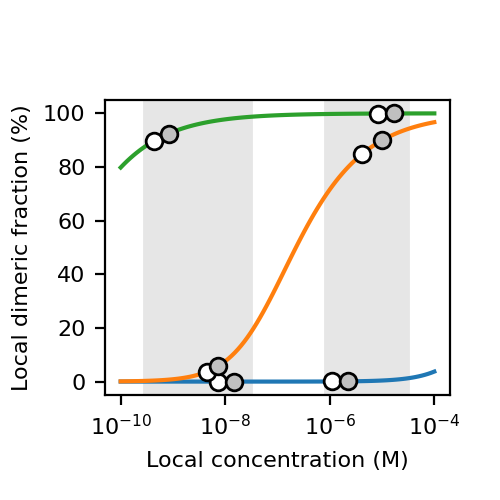

In [23]:
fig, ax = plt.subplots()
local_concentrations = np.linspace(-10, -4, 100)

# # Minor lines
# for d in dim_energies:
#     # Dimer titration curve
#     mon = dimerisation(wd=d, tot=10**local_concentrations)
#     dim_frac = 100 * ((10 ** local_concentrations) - mon) / (10 ** local_concentrations)
#     ax.plot(local_concentrations, dim_frac, c='silver', linewidth=0.5)
   
# Major lines
for d in select_energies:
    
    # Dimer titration curve
    mon = dimerisation(wd=d, tot=10**local_concentrations)
    dim_frac = 100 * ((10 ** local_concentrations) - mon) / (10 ** local_concentrations)
    ax.plot(local_concentrations, dim_frac)
    
    # Cytoplasmic and membrane concentrations - full dosage
    cyt = model2(np.exp(d), np.exp(wm), alpha=svr*D, d=dos_max)
    mem = (dos_max - cyt) / (svr*D)
    
    # Cytoplasmic and membrane dimerisation - full dosage
    cyt_mon = dimerisation(wd=d, tot=cyt)
    mem_mon = dimerisation(wd=d, tot=mem)
    cyt_dim_frac = 100 * (cyt - cyt_mon) / cyt
    mem_dim_frac = 100 * (mem - mem_mon) / mem
    ax.scatter(np.log10(cyt), cyt_dim_frac, zorder=10, c='silver', edgecolors='k')
    ax.scatter(np.log10(mem), mem_dim_frac, zorder=10, c='silver', edgecolors='k')
    
    # Cytoplasmic and membrane concentrations - half dosage
    cyt = model2(np.exp(d), np.exp(wm), alpha=svr*D, d=dos_max / 2)
    mem = ((dos_max / 2) - cyt) / (svr*D)
    
    # Cytoplasmic and membrane dimerisation - half dosage
    cyt_mon = dimerisation(wd=d, tot=cyt)
    mem_mon = dimerisation(wd=d, tot=mem)
    cyt_dim_frac = 100 * (cyt - cyt_mon) / cyt
    mem_dim_frac = 100 * (mem - mem_mon) / mem
    ax.scatter(np.log10(cyt), cyt_dim_frac, zorder=5, c='w', edgecolors='k')
    ax.scatter(np.log10(mem), mem_dim_frac, zorder=5, c='w', edgecolors='k')
    
# Shaded regions
ax.axvspan(-9.55, -7.5, color='0.9')
ax.axvspan(-6.1, -4.5, color='0.9')
 
ax.tick_params(axis='both', labelsize=8)
ax.set_xlabel('Local concentration (M)', fontsize=8)
ax.set_ylabel('Local dimeric fraction (%)', fontsize=8)
ax.xaxis.set_major_formatter(fake_log)
# minor_ticks(ax, y=False)

fig.set_size_inches(2.5, 2.5)
fig.subplots_adjust(bottom=0.21, left=0.21, top=0.8)
fig.savefig('Figs/dimerisation.png', dpi=600, transparent=True)